In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (15, 5)

In [2]:
tickers = ['xle', 'xlu', 'xlb', 'xlk', 'xli', 'xlv', 'xlf', 'xlp', 'xly']
end_date = '2023-07-16'

In [3]:
price_dataframe = yf.download(tickers)['Close']

preprocessed_dataframe = price_dataframe.fillna(method='ffill')
preprocessed_dataframe = preprocessed_dataframe.dropna()

[*********************100%***********************]  9 of 9 completed


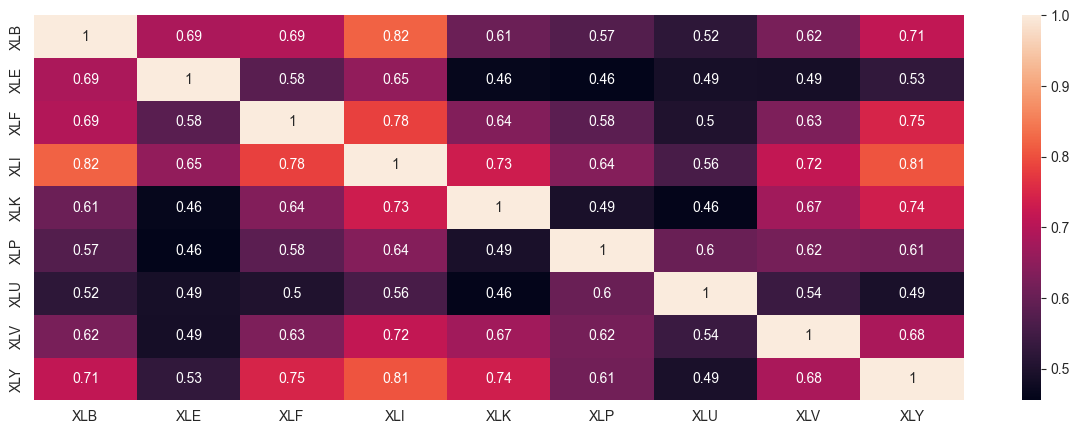

In [4]:
normalizedDataframe = preprocessed_dataframe.pct_change().dropna()

sns.heatmap(normalizedDataframe.corr(), annot=True)
plt.show()

In [5]:
lookbacks = np.arange(2, (21*12)+1, 1)

In [6]:
def getSignal(dataframe, lookback, cross_sectional, short, flip):
    signal = dataframe.rolling(lookback).sum()
    if flip:
        signal *= -1

    if cross_sectional:
        means = signal.mean(axis=1)
        stds = signal.std(axis=1)
        normalized_signal = (signal.values - means.values[:, np.newaxis]) / stds.values[:, np.newaxis]
        signal = pd.DataFrame(normalized_signal, index=signal.index, columns=signal.columns)

    positive_signal = signal[signal > 0]
    positive_weights = positive_signal.rank(axis=1, method='first', ascending=True)
    positive_weights = positive_weights.div(positive_weights.sum(axis=1), axis=0)
    if short:
        negative_signal = signal[signal < 0]
        negative_weights = negative_signal.rank(axis=1, method='first', ascending=False)
        negative_weights = negative_weights.div(negative_weights.sum(axis=1), axis=0)
        weights = positive_weights.combine_first(negative_weights)
    else:
        weights = positive_weights

    signal = np.sign(signal)

    return signal.mul(weights)

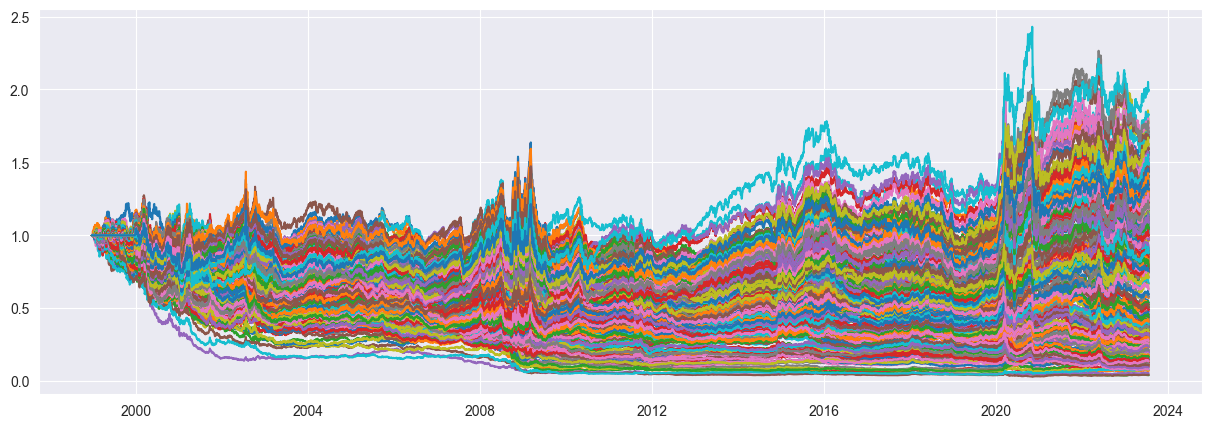

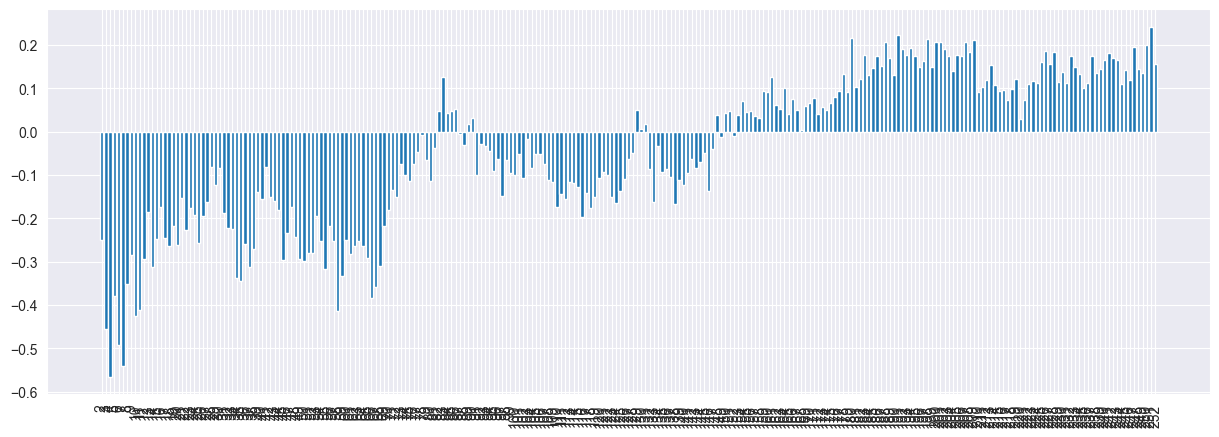

In [14]:
def backtest(dataframe, lookbacks, sharpes):
    for lookback in lookbacks:

        weighted_signal = getSignal(dataframe, lookback, cross_sectional=False, short=True, flip=False)

        portfolio_returns = (weighted_signal.shift() * dataframe).sum(axis=1)

        cumulative_returns = (portfolio_returns + 1).cumprod()

        plt.plot(cumulative_returns)

        # print('Sharpe', (portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)))
        sharpes.append((portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)))

    # plt.legend(lookbacks)
    plt.show()

    plt.bar(lookbacks, sharpes, tick_label=lookbacks)
    plt.xticks(rotation=90)

    # sns.heatmap(np.array(sharpes).reshape(len(lookbacks), len(lookbacks)), xticklabels=lookbacks, yticklabels=lookbacks)
    # plt.show()

backtest(normalizedDataframe, lookbacks, [])

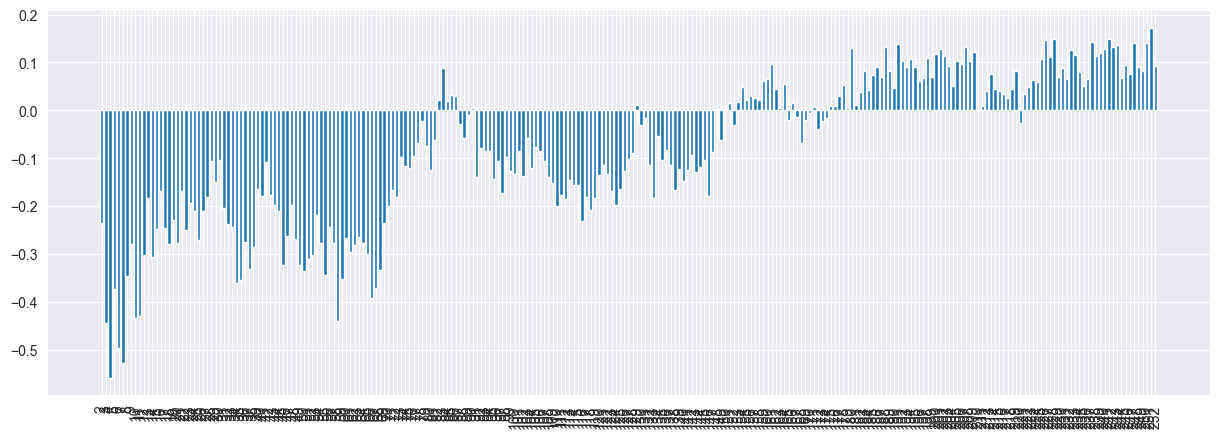

In [15]:
# divide dataframe into 2 and combine the average scores of both sharpes and mdds and plot that
def backtest(dataframe, lookbacks):
    first = dataframe.iloc[:int(len(dataframe)/3)]
    second = dataframe.iloc[int(len(dataframe)/3):int(len(dataframe)/3)*2]
    third = dataframe.iloc[int(len(dataframe)/3)*2:]

    dataframes = [first, second, third]

    sharpes = np.zeros((len(lookbacks), 3))

    for i, dataframe in enumerate(dataframes):
        # print('Fold', i+1)
        for j, lookback in enumerate(lookbacks):

            weighted_signal = getSignal(dataframe, lookback, cross_sectional=False, short=True, flip=False)

            portfolio_returns = (weighted_signal.shift() * dataframe).sum(axis=1)
            cumulative_returns = (portfolio_returns + 1).cumprod()
            # plt.plot(cumulative_returns)

            # print(lookback)
            # print('Sharpe', (portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)))
            sharpes[j, i] = (portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252))

    sharpes = sharpes.mean(axis=1)

    plt.bar(lookbacks, sharpes, tick_label=lookbacks)
    plt.xticks(rotation=90)
    plt.show()

    return np.argmax(sharpes)

highest_sharpe = backtest(normalizedDataframe, lookbacks)

Best Lookback Window 251


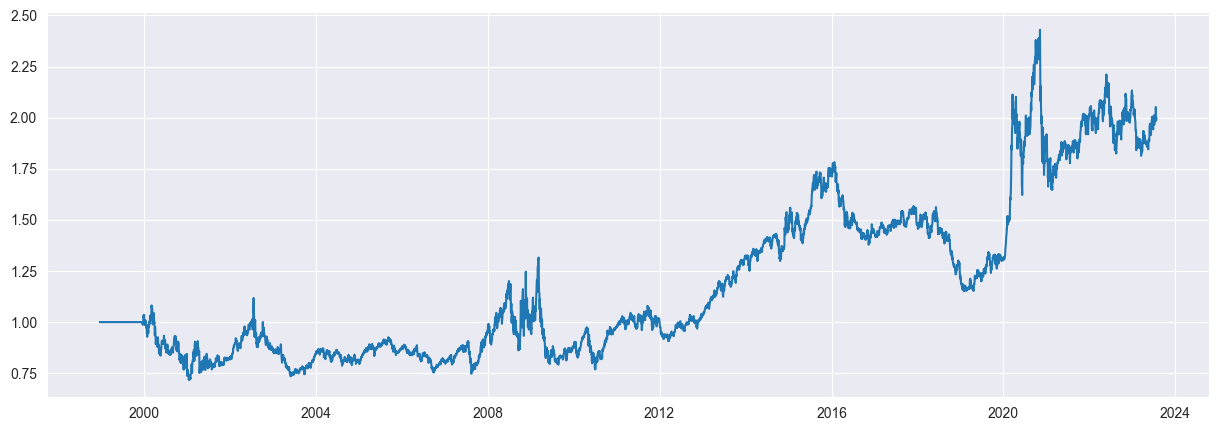

Sharpe: 0.243
Individual asset returns to strategy (highest to lowest): 
XLK    1.097423
XLE    0.455778
XLF    0.399764
XLI    0.032766
XLY   -0.013362
XLB   -0.101374
XLU   -0.193384
XLP   -0.245455
XLV   -0.268817
dtype: float64


In [16]:
def backtest(dataframe, highest_sharpe):
    lookback = lookbacks[highest_sharpe]

    print('Best Lookback Window', lookback)

    weighted_signal = getSignal(dataframe, lookback, cross_sectional=False, short=True, flip=False)

    # print('Current weights as a % of portfolio:')
    # print(weighted_signal.iloc[-1] * 100)

    portfolio_returns = (weighted_signal.shift() * dataframe).sum(axis=1)
    cumulative_returns = (portfolio_returns + 1).cumprod()
    plt.plot(cumulative_returns)

    plt.show()

    print('Sharpe:', round((portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)), 3))

    column_returns = (weighted_signal.shift() * dataframe).sum()
    print('Individual asset returns to strategy (highest to lowest): ')
    print(column_returns.sort_values(ascending=False))

backtest(normalizedDataframe, highest_sharpe)

# Notes

The best lookback window for this long short time-series momentum strategy is 251 days (one day less than a year), and the highest returning sector is tech. I wonder if the reason the 251 day lookback window performs the best has something to do with front running 252 day momentum strategies that most people run.